In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune
from torchsummary import summary

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class ScaledConvLayer(nn.Module):
  def __init__(self, dim, conv_layer):
    super().__init__()
    self.scale_factors = nn.Parameter(torch.rand(dim, requires_grad=True))
    self.conv_layer = conv_layer

  def forward(self, x):
    self.conv_layer.weight.mul(F.normalize(self.scale_factors))
    return self.conv_layer(x)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ScaledConvLayer([6, 1, 1, 1], nn.Conv2d(1,6, 5))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = ScaledConvLayer([16, 1, 1, 1], nn.Conv2d(6, 16, 5))
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
net = Net()

In [ ]:
threshnet_spoof = torch.tensor([0.7, 0.7])
test_img = torch.rand([1, 1, 28, 28])
net(test_img)

tensor([[ 0.0459, -0.1262, -0.0151,  0.1165, -0.0010, -0.1188,  0.0180,  0.1209,
          0.1055, -0.0909]], grad_fn=<AddmmBackward0>)

In [ ]:
import torchvision

from google.colab import drive

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])
    ])

batch_size = 4

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.384
[1,  4000] loss: 0.680
[1,  6000] loss: 0.583
[1,  8000] loss: 0.539
[1, 10000] loss: 0.482
[1, 12000] loss: 0.463
[1, 14000] loss: 0.427
[2,  2000] loss: 0.392
[2,  4000] loss: 0.399
[2,  6000] loss: 0.392
[2,  8000] loss: 0.374
[2, 10000] loss: 0.361
[2, 12000] loss: 0.355
[2, 14000] loss: 0.362
Finished Training


In [ ]:
PATH = './pretrained_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()

net.load_state_dict(torch.load('pretrained_net.pth'))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

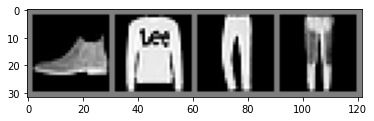

GroundTruth:  Ankle Boot Pullover Trouser Trouser


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by r`unning images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [ ]:
class SamplerPruneLayer(prune.BasePruningMethod):
  PRUNING_TYPE = 'unstructured'
  def __init__(self, thresh):
    self.thresh = thresh

  def compute_mask(self, al, default_mask):
    nl = al - torch.log(torch.rand(al.size()))
    nl = F.softmax(nl, dim = 0)
    c = 1
    for x in range(al.size()[0]):
        x, _ = torch.topk(nl, c, dim = 0)
        s = torch.sum(x)
        c = c + 1
        if(s > self.thresh):
          break
    _, idx = torch.topk(al, c, dim=0)
    mask = torch.zeros(al.size())
    mask[idx] = 1
    return mask

def prune_layer(module, name, thresh):
  SamplerPruneLayer.apply(module, name, thresh)
  return module

In [ ]:
def update_net(module, name):
  old_weights = torch.clone(getattr(module, name+"_orig"))
  old_mask = torch.clone(getattr(module, name+"_mask")) < 1
  prune.remove(module, name)
  with torch.no_grad():
    layer = getattr(module, name)
    layer[old_mask] = old_weights[old_mask]

In [ ]:
num_subnets = 6
loss_tracker = []
thresh1, thresh2 = (0.7, 0.7)

for j in range(0, num_subnets):
    print("*--------Sample and Train Start--------*")
    print("Sampling {}th subnetwork".format(i+1))
    prune_layer(net.conv1, 'scale_factors', thresh1)
    prune_layer(net.conv2, 'scale_factors', thresh2)    
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                loss_tracker.append(running_loss / 2000)
                running_loss = 0.0
    print("Saving network weights")
    PATH = './pretrained_net_subnet{}.pth'.format(j)
    torch.save(net.state_dict(), PATH)
    print("Mapping network weights back to larger network")
    update_net(net.conv1, 'scale_factors')
    update_net(net.conv2, 'scale_factors')
    print("*--------Sample and Train Done--------*")

*--------Sample and Train Start--------*
Sampling 1th subnetwork
[1,  2000] loss: 0.355
[1,  4000] loss: 0.343
[1,  6000] loss: 0.362
[1,  8000] loss: 0.341
[1, 10000] loss: 0.365
[1, 12000] loss: 0.348
[1, 14000] loss: 0.351
[2,  2000] loss: 0.361
[2,  4000] loss: 0.363
[2,  6000] loss: 0.344
[2,  8000] loss: 0.333
[2, 10000] loss: 0.364
[2, 12000] loss: 0.361
[2, 14000] loss: 0.347
Saving network weights
Mapping network weights back to larger network
*--------Sample and Train Done--------*
*--------Sample and Train Start--------*
Sampling 2th subnetwork
[1,  2000] loss: 0.352
[1,  4000] loss: 0.348
[1,  6000] loss: 0.356
[1,  8000] loss: 0.364
[1, 10000] loss: 0.355
[1, 12000] loss: 0.340
[1, 14000] loss: 0.353
[2,  2000] loss: 0.353
[2,  4000] loss: 0.347
[2,  6000] loss: 0.353
[2,  8000] loss: 0.356
[2, 10000] loss: 0.350
[2, 12000] loss: 0.340
[2, 14000] loss: 0.366
Saving network weights
Mapping network weights back to larger network
*--------Sample and Train Done--------*
*-----

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by r`unning images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [ ]:
net = Net()
#prune layer has no lasting impact
#these two lines add the attributes needed to load the state dict
prune_layer(net.conv1, "scale_factors", 0.1)
prune_layer(net.conv2, "scale_factors", 0.2)

net.load_state_dict(torch.load('pretrained_net_subnet6.pth'))

<All keys matched successfully>

In [ ]:
conv_elim_1 = int(torch.sum(net.conv1.scale_factors_mask==0))
conv_elim_2 = int(torch.sum(net.conv2.scale_factors_mask==0))
print("{} convolutions are eliminated from layer 1".format(conv_elim_1))
print("{} convolutions are eliminated from layer 2".format(conv_elim_2))

1 convolutions are eliminated from layer 1
11 convolutions are eliminated from layer 2


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by r`unning images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


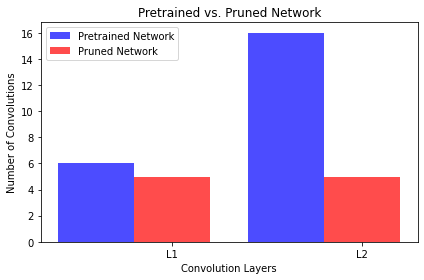

In [ ]:
n_groups = 2
pretrained_net_stats = (6, 16)
pruned_net_stats = (5, 5)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.7

rects1 = plt.bar(index, pretrained_net_stats, bar_width,
alpha=opacity,
color='b',
label='Pretrained Network')

rects2 = plt.bar(index + bar_width, pruned_net_stats, bar_width,
alpha=opacity,
color='r',
label='Pruned Network')

plt.xlabel('Convolution Layers')
plt.ylabel('Number of Convolutions')
plt.title('Pretrained vs. Pruned Network')
plt.xticks(index + bar_width, ('L1', 'L2'))
plt.legend()

plt.tight_layout()
plt.show()

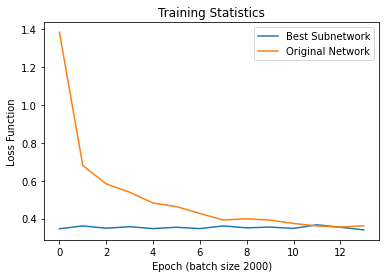

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

subnet_accuracy = [0.346, 0.361, 0.349, 0.357, 0.347, 0.354, 0.347, 0.361, 0.351, 0.355, 0.348, 0.367, 0.354, 0.340]
pretrained_accuracy = [1.384, 0.680, 0.583, 0.539, 0.482, 0.463, 0.427, 0.392, 0.399, 0.392, 0.374, 0.361, 0.355, 0.362]
epoch = np.arange(14)

plt.plot(epoch, subnet_accuracy, label = "Best Subnetwork")
plt.plot(epoch, pretrained_accuracy, label = "Original Network")
plt.xlabel("Epoch (batch size 2000)")
plt.ylabel("Loss Function")
plt.title("Training Statistics")
plt.legend()